# Coding Exercise 3

## Question 1: Optimal Consumption with Income Fluctuations

### The model

Consider a household that maximize

$$
\max_{\{c_t\}_{t = 0}^\infty } \mathbb{E} \sum_{t=0}^{\infty} \beta^t u(c_t),
$$
where $ \beta \in (0,1) $ is the discount factor and $ c_t $ is consumption at time $t$  

subject to

<a id='resource_constraint'></a>
$$
a_{t+1} \leq  (1+r_t) a_t  + w_t h_t - c_t,
\quad c_t \geq 0,
\quad a_t \geq 0
\quad t = 0, 1, \ldots \tag{1}
$$

where

- $ \beta \in (0,1) $ is the discount factor.
- $ a_t $ is asset holdings at the beginning of time $ t $ with a borrowing constraint: $ a_t \geq 0 $ $\forall t$. 
- $ c_t $ is consumption, and $h_t$ is hours worked.
- $ w_t $ is wages and $ r_t $ is the interest rate.

Each period, the household is endowed with one unit of time. Due to the specification of utility function the household inelastically supply the whole hour as labor, i.e., $h_t=1$ for all $t$.

The interest rate ($r_t$) and wages ($w_t$) are given, respectively, $r_t = r(Z_t)$ and $w_t = w(Z_t)$, where $Z_t$ follows a finite state Markov process with a state space $\mathcal{Z}=\{0,1\}$ and a Markov matrix as below:

$$
P = \left[\begin{matrix}
    0.9 & 0.1 \\
    0.1 & 0.9
    \end{matrix}\right]
$$

For simplicity of computation, We assume that $r(0)=0.025$, $r(1)=0.035$, $w(0)=0.8$ and $w(1)=1.2$.

Notice that the resource constraint for the household in [(1)](#resource_constraint) is different from the one that we considered in the lecture. This represents the timing of events within a period as follows:

1. In period $ t $, the household starts the period with asset holds $a_t$ which transmitted from the previous period.
1. At the beginning of period $ t $, the household observes the realizations of the interest rate and wages, $r_t$ and $w_t$ which are determined accoding to the Markov processes.
1. The household receives the gross capital income $(1+r_t) a_t$ and labor income $w_t h_t$. 
1. The household chooses her consumption $c_t$.
1. Time shifts to $ t+1 $ and the process repeats.

It is clear that the state for the household is a pair of $ (a,z) \in \mathsf S := \mathbb R_+ \times \mathcal{Z} $. 

### The Euler Equation

In period $t$, the total resources for the houshold is $(1+r_{t})a_t + w_t$ is disposed of into consumption $c_t$ and the next period asset $a_{t+1}$. Due to the borrowing constraint, $a_{t+1} \ge 0$. Taking this into consideration, the optimal condition for the consumption choices can be summarized by the following Euler equation:

<a id='euler_equation'></a>
$$
u'(c_t) = \max \left\{\beta\, \mathbb{E}_t \left[ (1+r_{t+1}) u'(c_{t+1}) \right], \;  u'\left((1+r_{t})a_t+w_t\right)
\right\} \tag{2}
$$

There exists an *optimal consumption function* $ \sigma^* \colon \mathsf S \to \mathbb R_+ $ that solves [(2)](#euler_equation) for all $ (a,z) \in \mathsf{S} $, i.e., 

<a id='EE'></a>
$$
\begin{aligned}
(u' \circ \sigma) (a, z) &= \max \left\{\beta\, \mathbb{E}_z \left[ \left(1+r(\hat{z})\right) (u' \circ \sigma) (\hat{a},\hat{z}) \right], \;  u'\left((1+r(z))a+w[z]\right) \right\}
\\
&= \max \left\{\beta\, \mathbb{E}_z \left[ \left(1+r(\hat{z})\right) (u' \circ \sigma) \left((1+r(z))a+w[z]-\sigma(a,z),\hat{z} \right) \right], \;  u'\left((1+r(z))a+w[z]\right) \right\}
\end{aligned}
\tag{3}
$$


Let's solve for the optimal policy for consumption through the **time iteration** method.

### Q.1-0: Import necessary packages.

First, import the following external libraries:

1. `MarkoovChain`**(typo)** from `quantecon` to handle finite state Markov process
1. `brentq` from `quantecon` to solve for the optimal policy at each state. 
1. `interp` from `interpolation` to evaluate the optimal policy an off-grid point.
1. `numba` package to jit-compile class and functions.
1. `pyplot` from `matplotlib` to present results graphically.

In [1]:
# your code here
from quantecon import MarkovChain
from quantecon.optimize import brentq
from interpolation import interp

# import numba
from numba.experimental import jitclass
from numba import njit, float64

import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt

### Q.1-1: Define the class for the model economy

Write a class **IFP** that specifies the following.

- discount factor: $\beta = 0.965$
- CRRA parameter: $\gamma=2$
- interest rate values: as specified above
- wage values: as specified above
- Markov matrix: P as specified above
- marginal uility function: $c^{-\gamma}$
- asset grid vector: $a \in [0, 20]$ with grid_size = 200
- collect the model parameters and declare their types in **ifp_data**
- jit-compile the class with `@jitclass`

Assume that the condition for convergence, $\beta E[1+r(\hat{z})] < 1$ is satisfied with the above values for `r` and `beta`.

In [2]:
# your code here
ifp_data = [
    ('beta', float64), # discount factor
    ('gamma', float64), # CRRA param
    ('r', float64[:]), # interest rate
    ('w', float64[:]), # wage
    ('markov_mat', float64[:,:]), # transition probability matrix
    ('asset_grid', float64[:]) # asset_grid
]

@jitclass(ifp_data)
class IFP:
    def __init__(self,
                 beta=0.965,
                 gamma=2,
                 r=np.array([0.025, 0.035]), # r(0)=0.025, r(1)=0.035
                 w=np.array([0.8, 1.2]),     # w(0)=0.8,   w(1)=1.2
                 markov_mat=np.array([(0.9, 0.1),
                                      (0.1, 0.9)]),
                 grid_max=20,
                 grid_size=200):
        self.beta = beta
        self.gamma = gamma
        self.r = r
        self.w = w
        self.markov_mat = markov_mat
        self.asset_grid = np.linspace(0, grid_max, grid_size)
        
        _prob = self.markov_mat[1,0] / (self.markov_mat[0,1]+self.markov_mat[1,0])
        _z_hat = np.array([_prob, 1 - _prob])
        
        assert beta * np.mean(1 + self.r * _z_hat) < 1, "Model param does not satisfy the convergence condition"
        
    def u_prime(self, c):
        return c ** (-self.gamma)
    
    def euler_diff(self, c, a, z, sigma_mat):
        # returns (𝑢′∘𝜎)(𝑎,𝑧) - max{𝛽𝔼𝑧[(1+𝑟(𝑧̂ ))(𝑢′∘𝜎)((1+𝑟(𝑧))𝑎+𝑤[𝑧]−𝜎(𝑎,𝑧),𝑧̂ )],𝑢′((1+𝑟(𝑧))𝑎+𝑤[𝑧])} from eq.(3)
        # Linear interpolation
        sigma = lambda a,z: interp(self.asset_grid, sigma_mat[:, z], a)
        R = 1 + self.r[z]

        # Calculate the expectation
        expect = float(0)
        for z_hat in range(2):
            c_ = sigma(R * a + self.w[z] - c, z_hat)
            expect += self.markov_mat[z, z_hat] * (1 + self.r[z_hat]) * self.u_prime(c_)
            
        first = self.beta * expect
        second = self.u_prime(R * a + self.w[z])
        out = self.u_prime(c) - max(first, second)
        
        return out

### Q.1-2: Define the Coleman Operator

Write a function that defines the Coleman operator $K$ that updates the optimal policy function $\sigma$ by solving the (nonlinear) Equler equation for $c$ for all $(a,z) \in \mathsf{S}$. 

<a id='EE_sigma'></a>
$$
u'(c) = \max \left\{\beta\, \mathbb{E}_z \left[ \left(1+r(\hat{z})\right) (u' \circ \sigma) \left((1+r(z))a+w[z]-c,\hat{z} \right) \right], \;  u'\left((1+r(z))a+w[z]\right) \right\}
\tag{4}
$$

- function head: **K($\sigma$, ifp)**
- $\sigma$ is a matrix of which elements are the optimal consumption $c^*$ for state $(a,z) \in \mathsf S$ in the current iteration.
- `ifp` is the instance of the class IFP to be initiated later.
- solve the nonlinear euqation for $c^*$ for each pair of $(a,z)$ using `brentq` function. You may refer to [this site](https://quanteconpy.readthedocs.io/en/latest/optimize/root_finding.html) to find the usage of `brentq`.
- update the policy value function $\sigma_{new}$.
- jit-compile the function with @njit

In [3]:
# your code here
@njit
def K(sigma, ifp):
    sigma_new = np.empty_like(sigma)
    
    for i, a in enumerate(ifp.asset_grid):
        for z in (0, 1):
            h = 1
            upper_bound = (1+ifp.r[z]) * a + ifp.w[z]
            result = brentq(ifp.euler_diff, 1e-8, upper_bound, args=(a, z, sigma))
            sigma_new[i, z] = result.root

    return sigma_new

### Q.1-3: Implement the Time Iteration


Write a function that iterates the Coleman operator until the policy function converges. 

- function head: `solve_model_(ifp_in, $\sigma$, tol=1e-4, max_iter=1000, print_skip=10)`
- the arguements are analogous to those in the lecture.
- while iterating, the function should show the progress every 10 iteration.
- the function returns the converged policy function.

In [4]:
# your code here
def solve_model_(ifp_in,
                 sigma,
                 tol=1e-4,
                 max_iter=1000,
                 print_skip=10):

    # Set up loop
    i = 0

    while i < max_iter:
        sigma_new = K(sigma, ifp_in)
        error = np.max(np.abs(sigma - sigma_new)) # calculate Chebyshev distance
        i += 1
            
        sigma = sigma_new # Update policy
        
        if error < tol:
            print('Early stopping due to tolerance')
            print('Curr iter: {:-4} / {}'.format(i, max_iter), '| Error: %.4f' % error)
            break

        if i % print_skip == 0: 
            print('Curr iter: {:-4} / {}'.format(i, max_iter), '| Error: %.4f' % error)

    if i == max_iter:
        print("Failed to converge!")

    if i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return sigma_new

### Q.1-4: Run the Time Iteration

- create an instance of the class IFP `ifp` with the default parameter values defined in the class.
- initialize the optimal consumption matrix $\sigma$ with the asset grid vector for all $z$.
- run `solve_model` and save the converged comsumption policy in a matrix *c_opt*.
- compute the optimal asset holdings in the next period, $\hat{a}$, using *c_opt* and the resource constraint and save them in a matrix *ap_opt*.
- plot *c_opt* for each $z$ against assets ($a$).
- plot *ap_opt* for each $z$ against assets ($a$).


In [5]:
# your code here
ifp = IFP()

# Set up initial consumption policy of consuming all assets at all z
z_size = len(ifp.markov_mat)
a_grid = ifp.asset_grid
a_size = len(a_grid)
sigma_init = np.repeat(a_grid.reshape(a_size, 1), z_size, axis=1)
# initial policy -> consume all the asset

c_opt = solve_model_(ifp, sigma_init, max_iter=2000)
# 𝑎𝑡+1≤(1+𝑟𝑡)𝑎𝑡+𝑤𝑡ℎ𝑡−𝑐𝑡,
ap_opt = np.empty_like(c_opt)
for i, a in enumerate(a_grid):
    for z in range(2):
        ap_opt[i, z] = (1+ifp.r[z]) * a + ifp.w[z] - c_opt[i, z] 

Curr iter:   10 / 2000 | Error: 0.1780
Curr iter:   20 / 2000 | Error: 0.0452
Curr iter:   30 / 2000 | Error: 0.0189
Curr iter:   40 / 2000 | Error: 0.0096
Curr iter:   50 / 2000 | Error: 0.0059
Curr iter:   60 / 2000 | Error: 0.0043
Curr iter:   70 / 2000 | Error: 0.0029
Curr iter:   80 / 2000 | Error: 0.0019
Curr iter:   90 / 2000 | Error: 0.0012
Curr iter:  100 / 2000 | Error: 0.0008
Curr iter:  110 / 2000 | Error: 0.0005
Curr iter:  120 / 2000 | Error: 0.0004
Curr iter:  130 / 2000 | Error: 0.0002
Curr iter:  140 / 2000 | Error: 0.0001
Early stopping due to tolerance
Curr iter:  150 / 2000 | Error: 0.0001

Converged in 150 iterations.


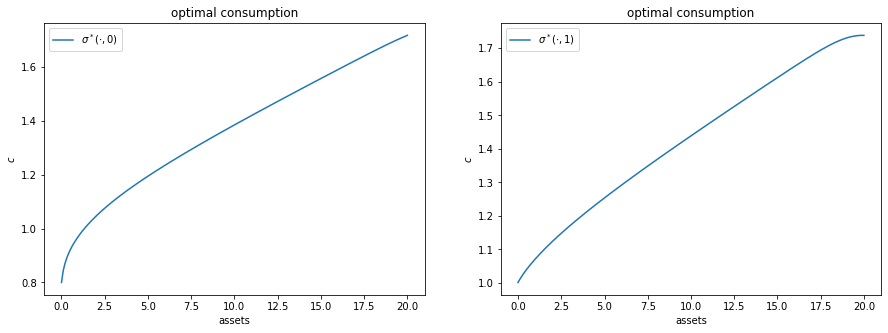

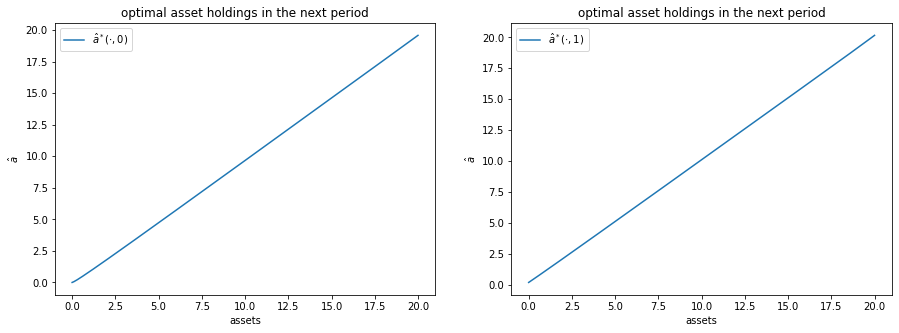

In [6]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

for z, ax in enumerate(axs):
    label = rf'$\sigma^*(\cdot, {z})$'
    ax.plot(ifp.asset_grid, c_opt[:, z], label=label)
    ax.set(xlabel='assets', ylabel=r'$c$',
           title='optimal consumption')
    ax.legend()

fig, axs = plt.subplots(1,2, figsize=(15,5))

for z, ax in enumerate(axs):
    label = r'$\hat{a}^*$' + rf'$(\cdot, {z})$'
    ax.plot(ifp.asset_grid, ap_opt[:, z], label=label)
    ax.set(xlabel='assets', ylabel=r'$\hat{a}$', 
            title='optimal asset holdings in the next period')
    ax.legend()

plt.show()

### Q.1-5: Simulate the time-series of asset holdings

Suppose that the household is endowed with $a_0$ at the very first period of her life. Each period, she chooses consumption and the next period assets according to the optimal policy function computed above. Write a function that simulates the asset holdings and consumption of the household over 500,000 periods.

- function head: Simulate_Time_Series(ifp, T, seed=1234)
    - `ifp`: instance of the class IFP
    - `c_opt`: optimal consumption function computed above
    - `T`: length of time-series, set to 500,000
    - `seed`: seed for random number generator, set to 1234
- need to interpolate policy functions
- use `MarkovChain` to generate a series of random numbers from a Markov process with Markov matrix P 
- compute and plot the time-series $\{a_t, c_t\}$ for $t=0, 1, \cdots T$.


In [7]:
# your code here
def Simulate_Time_Series(ifp, policy, T=int(5e5), seed=1234):
    np.random.seed(1234)
    mc = MarkovChain(ifp.markov_mat)
    z_series = mc.simulate(T)
    ts = np.zeros((T+1, 2)) # ts = {a, c}_t
    ts[0, 0] = np.random.random() * 20 # set a_0
    policy_func = lambda a,z: interp(ifp.asset_grid, policy[:, z], a)

    for t, z in enumerate(z_series):
        ts[t, 1] = policy_func(ts[t, 0], z)
        ts[t + 1, 0] = (1 + ifp.r[z]) * ts[t, 0] + ifp.w[z] - ts[t, 1] # store a_{t+1}
        
    return ts[:T] # drop the last row
ts = Simulate_Time_Series(ifp, c_opt)


### Q.1-6: Plot the time-series of assets and consumption

- Generate time-series for asset and consumption.
- Plot histograms of assets and consumption assuming that the generated time-series represent the cross-sectional distributions of assets and consumption.
- Plot the Lorenz curve and compute the Gini coefficients for assets and consumption.


In [8]:
data = []
for i in range(2):
    w = ts[:, i]
    fw, lw = qe.lorenz_curve(w)
    gini_fw = qe.gini_coefficient(w)
    data.append((fw, lw, gini_fw))

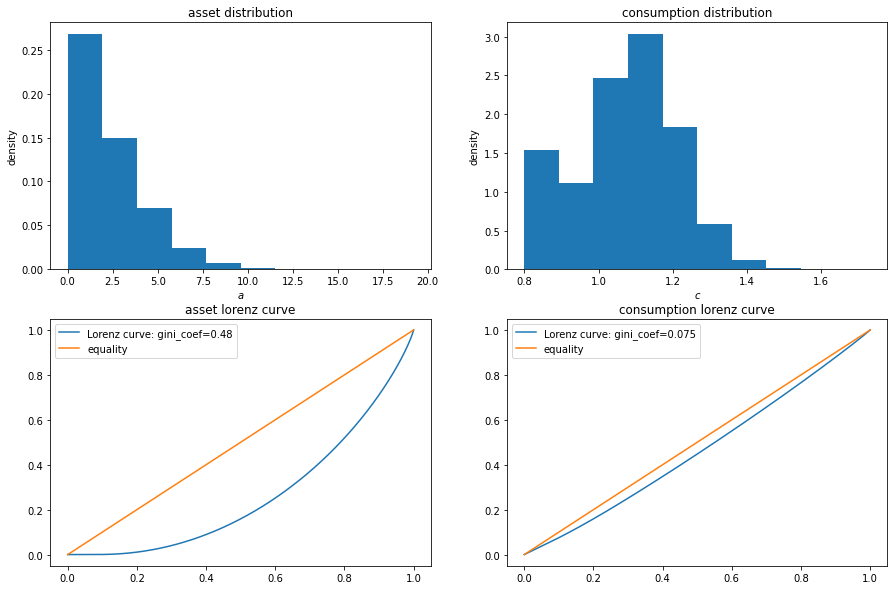

In [9]:
# your code here
fig, axs = plt.subplots(2,2, figsize=(15,10))
titles = ['asset', 'consumption']
labels = [r'$a$', r'$c$']

for i, ax in enumerate(axs[0]):
    ax.hist(ts[:, i], density=True)
    ax.set(xlabel=labels[i], ylabel='density', 
           title=f'{titles[i]} distribution')
    
# fig, axs = plt.subplots(1,2, figsize=(15, 5))
titles = ['asset','consumption']

for i, ax in enumerate(axs[1]):
    w = ts[:, i]
    fw, lw, gini_fw = data[i]
    

    ax.plot(fw, lw, label=f'Lorenz curve: gini_coef={gini_fw:.2}')
    ax.plot(fw, fw, label='equality')
    ax.set(title=titles[i] + ' lorenz curve')
    ax.legend()

plt.show()

## Question 2: Lake Model of Labor Markets

### The Model

The economy is inhabited by a very large number of ex-ante identical workers. Let's normalize the total number of workers (population) to unity. The workers live forever, spending their lives moving across three labor market states: employment ($E$), unemployment ($U$) and out of labor force ($O$). There are six possible transitions across three states over the course of two consecutive periods.

1. An employed worker in period $t$ becomes unemployed in the next period with probability $\alpha$.
1. An employed worker in period $t$ goes out of labor force in the next period with probability $\delta$.
1. An unemployed worker in period $t$ become employed in the next period with probability $\lambda$.
1. An unemployed worker in period $t$ goes out of labor firce in the next period with probability $\kappa$.
1. A worker out of labor force in period $t$ becomes employed in the next period with probability $\eta$.
1. A worker out of labor force in period $t$ becomes unemployed in the next period with probability $\chi$.


### Laws of Motion for Stock Variables

Labor market stock variables evolve over time according to the following laws of motion. 

1. Employment:
$$
E_{t+1} = (1-\alpha-\delta) E_t + \lambda U_t + \eta O_t
$$

1. Unemployment:
$$
U_{t+1} = \alpha E_t + (1-\lambda-\kappa) U_t + \chi O_t  
$$

1. Out of Labor Force:
$$
O_{t+1} = \delta E_t + \kappa U_t + (1-\eta-\chi) O_t
$$


Let $ X := \left(\begin{matrix} E & U & O \end{matrix}\right) $. Then the law of motion for $ X $ is $X_{t+1} = X_t P$, where 

$$
P = \left[\begin{matrix}
     1-\alpha-\delta & \alpha & \delta \\
     \lambda & 1-\lambda-\kappa & \kappa \\
     \eta & \chi & 1-\eta-\chi \\
    \end{matrix}\right]
$$


### Q.2-1: Define the class for the lake model of labor market

Write a class **Lake** that specifies the following. In the class definition, make the Markov matrix to immediately reflect changes in individual transition probabilities without re-creating the instance of the class. For this, Use descriptors and decorators such as `@property` as we did in the lecture.

- Transition probabilities
    - from E to U: $\alpha = 0.0147$
    - from E to O: $\delta = 0.0313$
    - from U to E: $\lambda = 0.2774$
    - from U to O: $\kappa = 0.2280$
    - from O to E: $\eta = 0.0466$
    - from O to U: $\chi = 0.0245$
- function `__init__`: sets default values for transition probabilities and generate a Markov matrix `P` by calling `construct_P`
- function `construct_P`: construct a Markov matrix `_P`
- function `construct_mc`: construct a Markov Chain object `_mc` with `P`
- using @property and @x.setter decorators, make inidividual transition probabilities and the Markov matrix to be changed.
- function `steady_state`: computes the steady state of the labor market
- function `simulate_stock_path`: simulate a time-series of labor market stock variables


In [10]:
# your code here
class Lake:
    def __init__(self,
                 alpha=0.0147,
                 delta=0.0313,
                 lamda=0.2774,
                 kappa=0.2280,
                 eta=0.0466,
                 chi=0.0245,
                 ):
        
        self._alpha = alpha
        self._delta = delta
        self._lamda = lamda
        self._kappa = kappa
        self._eta = eta
        self._chi = chi
        
        self.construct_P()

    def construct_P(self):
        _diag_1 = 1 - self._alpha - self._delta
        _diag_2 = 1 - self._lamda - self._kappa
        _diag_3 = 1 - self._eta - self._chi
        self._P = np.array([[_diag_1, self._alpha, self._delta],
                            [self._lamda, _diag_2, self._kappa],
                            [self._eta, self._chi, _diag_3]])
        self.construct_mc()
            
    def construct_mc(self):
        self.mc = MarkovChain(self.P)
    
    @property
    def alpha(self):
        return self._alpha
    
    @alpha.setter
    def alpha(self, new_val):
        self._alpha = new_val
        self.construct_P() 
        
    @property
    def delta(self):
        return self._delta
    
    @delta.setter
    def delta(self, new_val):
        self._delta = new_val
        self.construct_P()    
    
    @property
    def lamda(self):
        return self._lamda
    
    @lamda.setter
    def lamda(self, new_val):
        self._lamda = new_val
        self.construct_P()
        
    @property
    def kappa(self):
        return self._kappa
    
    @kappa.setter
    def kappa(self, new_val):
        self._kappa = new_val
        self.construct_P()    
        
    @property
    def eta(self):
        return self._eta
    
    @eta.setter
    def eta(self, new_val):
        self._eta = new_val
        self.construct_P()    
        
    @property
    def chi(self):
        return self._chi
    
    @chi.setter
    def chi(self, new_val):
        self._chi = new_val
        self.construct_P()
    
    @property
    def P(self):
        # Read only
        return self._P

    def steady_state(self, init=None, tol=1e-6):
        # Set an arbitrary initial state dist.
        if init is None:
            x = np.random.rand(3)
            x /= np.sum(x)
        else:
            condition = len(init) == 3 and np.sum(init) - 1 < 1e-6 and np.all(init > 0)
            assert condition, 'Wrong dist.'
            x = init

        err = tol + 1
        while err > tol:
            x_ = x @ self.P
            err = np.max(np.abs(x_ - x)) # Chebyshev distance
            x = x_
        
        return x
    
    def simulate_stock_path(self, init, T):
        condition = len(init) == 3 and np.sum(init) - 1 < 1e-6 and np.all(init > 0)
        assert condition, 'Wrong dist.'
        state = np.atleast_1d(init)
        for t in range(T):
            yield state
            state = state @ self.P

### How to avoid using replicative `@property` decorators
```python
class C:
    def __init__(self,
                 a=None,
                 b=None,
                 ):
        
        self._a = a
        self._b = b
        
    @property
    def a(self):
        return self._a

    @a.setter
    def a(self, new_val):
        self._a = new_val

    @property
    def b(self):
        return self._b

    @b.setter
    def b(self, new_val):
        self._b = new_val
```

We can see that all the getter and setter functions for each variable are identical.  
You may want to simplify your code by using a factory function to avoid tedious copy and paste procedure.  

The following code is modified from [Python Cookbook](http://bedford-computing.co.uk/learning/wp-content/uploads/2015/10/Python-Cookbook-3rd-Edition.pdf).  
Original source is on Ch.9.21 (p.382)

```python
def factory(name):
    storage_name = '_' + name
    
    @property
    def prop(self):
        return getattr(self, storage_name)
    
    @prop.setter
    def prop(self, value):
        setattr(self, storage_name, value)
    
    return prop

class C_modified:
    a = factory('a')
    b = factory('b')
    
    def __init__(self,
                 a=None,
                 b=None,
                 ):
        
        self._a = a
        self._b = b
```

Based on this pattern, `Lake_modified` class can be defined as follows.  
Modified model gives the same result with the original `Lake `model above.  
Results from identical simulation with the `Lake_modified` model are posted on the last part of the notebook.

In [11]:
# your code here
def factory(name):
    storage_name = '_' + name
    
    @property
    def prop(self):
        return getattr(self, storage_name)
    
    @prop.setter
    def prop(self, value):
        setattr(self, storage_name, value)
        self.construct_P()
    
    return prop

class Lake_modified:
    alpha = factory('alpha')
    delta = factory('delta')
    lamda = factory('lamda')
    kappa = factory('kappa')
    eta = factory('eta')
    chi = factory('chi')
    
    def __init__(self,
                 alpha=0.0147,
                 delta=0.0313,
                 lamda=0.2774,
                 kappa=0.2280,
                 eta=0.0466,
                 chi=0.0245,
                 ):
        
        self._alpha = alpha
        self._delta = delta
        self._lamda = lamda
        self._kappa = kappa
        self._eta = eta
        self._chi = chi
        
        self.construct_P()

    def construct_P(self):
        _diag_1 = 1 - self._alpha - self._delta
        _diag_2 = 1 - self._lamda - self._kappa
        _diag_3 = 1 - self._eta - self._chi
        self._P = np.array([[_diag_1, self._alpha, self._delta],
                            [self._lamda, _diag_2, self._kappa],
                            [self._eta, self._chi, _diag_3]])
        self.construct_mc()
            
    def construct_mc(self):
        self.mc = MarkovChain(self.P)

    @property
    def P(self):
        # Read only
        return self._P

    def steady_state(self, init=None, tol=1e-6):
        # Set an arbitrary initial state dist.
        if init is None:
            state = np.random.rand(3)
            state /= np.sum(state)
        else:
            condition = len(init) == 3 and np.sum(init) - 1 < 1e-6 and np.all(init > 0)
            assert condition, 'Wrong dist.'
            state = init

        err = tol + 1
        while err > tol:
            state_ = state @ self.P
            err = np.max(np.abs(state_ - state)) # Chebyshev distance
            state = state_
        
        return state
    
    def simulate_stock_path(self, init, T):
        condition = len(init) == 3 and np.sum(init) - 1 < 1e-6 and np.all(init > 0)
        assert condition, 'Wrong dist.'
        state = np.atleast_1d(init)
        for t in range(T):
            yield state
            state = state @ self.P

### Q.2-2: Compute the stationary distribution

We have learned from the lecture 11 (Finite Markov Chain) that if the Markov matrix is both irreducible and aperiodic, then there exist a unique stationary distribution of states. 

- create an instance of the class, `LM`.

In [12]:
# your code here
LM = Lake()

- check if the labor market is irreducible using a method in `quantecon.MarkovChain`

In [13]:
# your code here
LM.mc.is_irreducible

True

- check if the labor market is aperiodic using a method in `quantecon.MarkovChain`

In [14]:
# your code here
LM.mc.is_aperiodic

True

- compute the stationary distribution of labor market states using the function `stationary_distgribution` **(typo)** included in `quantecon.MarkovChain`.

In [15]:
# your code here
print(LM.mc.stationary_distributions)

[[0.59122535 0.03530098 0.37347367]]


- compute the stationary distribution of labor market states using the function `steady_state` included in the class `Lake`.

In [16]:
# your code here
print(LM.steady_state())

[0.5912167  0.03530118 0.37348212]


### Q.2-3: Simulate Labor Market Stocks

Let's simulate labor market stock variables for 50 periods, `T=50`, according to the system that we constructed with the class `Lake`.

- set initial values for labor market stocks: `X_0`
- compute the steady state of the labor market: `xbar`
- simulate labor market stocks with the function `simulate_stock_path`.
- plot the simulated labor market stock variables with their steady states.


initital  |[0.4862 0.1078 0.406 ] 
steady    |[0.5912 0.0353 0.3735] 
last      |[0.5908 0.0353 0.3739]


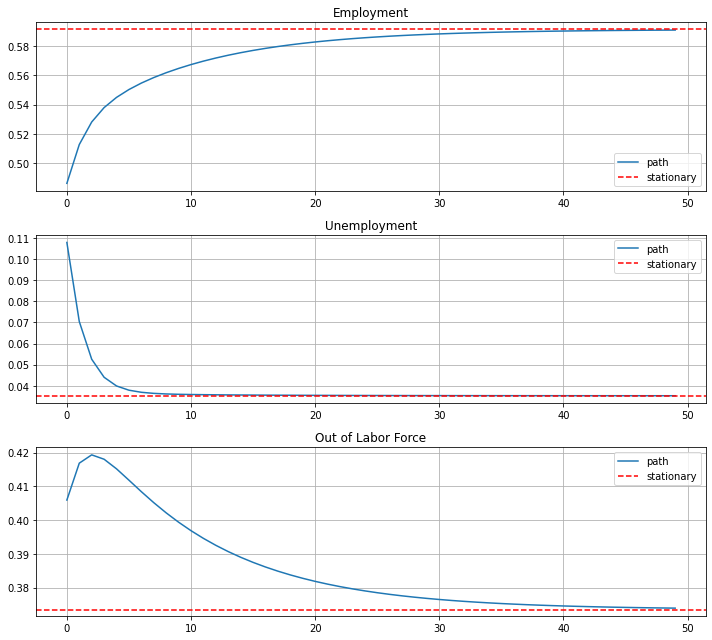

In [17]:
# your code here
np.random.seed(2015121120)
X_0 = np.abs(np.random.randn(3))
X_0 /= np.sum(X_0)

xbar = LM.steady_state(init=X_0)
path = np.vstack(tuple(LM.simulate_stock_path(init=X_0, T=50)))

print(
    f"{'initital':<10}|{str(np.around(X_0, 4)):>}",
    f"\n{'steady':<10}|{str(np.around(xbar, 4)):>}",
    f"\n{'last':<10}|{str(np.around(path[-1], 4)):>}"
)

fig, axs = plt.subplots(3, 1, figsize=[10, 9])

labels = ["Employment", "Unemployment", "Out of Labor Force"]
for i, ax in enumerate(axs):
    ax.plot(path[:, i], label='path')
    ax.axhline(xbar[i], color='red', label='stationary', linestyle='dashed')
    ax.set_title(labels[i])
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

### Q.2-4: An Invididual Worker's Turnover across Labor Market States

Let's simulate an individual worker's turnovers (transitions) across the labor market stock variables for $T=50,000$. Write codes for simulating and plotting the individual worker's turnovers across labor market states over time.

- simuate individual worker's state using Markov chain: `s_path`
- from `s_path`, construct a time series `e_path` that consists of 0 or 1 where 1 represents employment
- from `s_path`, construct a time series `u_path` that consists of 0 or 1 where 1 represents unemployment
- from `s_path`, construct a time series `o_path` that consists of 0 or 1 where 1 represents out of labor force
- using `e_path` generate a time series, `s_bar_e` of percentage of time employed until time $t$
- using `u_path` generate a time series, `s_bar_u` of percentage of time unemployed until time $t$
- using `o_path` generate a time series, `s_bar_o` of percentage of time out of labor force until time $t$
- plot `s_bar_e`, `s_bar_u`, `s_bar_o`

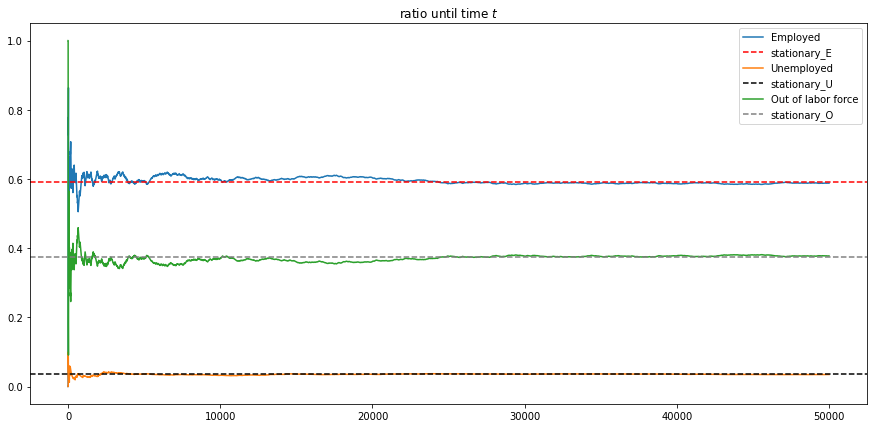

In [18]:
# your code here
np.random.seed(2015121120)
s_path = LM.mc.simulate(50000)
xbar = LM.steady_state()

def get_cum_density(path):
    out = []
    for s in range(3):
        binary_path = np.array(path == s, 'int')
        out.append(np.cumsum(binary_path) / np.arange(1, len(binary_path) + 1))
    return out

s_bar_e, s_bar_u, s_bar_o = get_cum_density(s_path)

plt.figure(figsize=(15,7))
plt.title(r'ratio until time $t$')

plt.plot(s_bar_e, label='Employed')
plt.axhline(xbar[0], color='red', label='stationary_E', linestyle='dashed')

plt.plot(s_bar_u, label='Unemployed')
plt.axhline(xbar[1], color='black', label='stationary_U', linestyle='dashed')

plt.plot(s_bar_o, label='Out of labor force')
plt.axhline(xbar[2], color='grey', label='stationary_O', linestyle='dashed')

plt.legend()
plt.show()

### Q.2-5: Effects of Changes in Transition Probabilities on Labor Market Stocks

Let's simulate the labor market stock variables for $T=50$ again. Now, suppose that the following changes in transition probabilites will take place in period $\hat{T} = 20$: $\hat{\alpha} = 0.03$ and $\hat{\delta} = 0.05$. In other words, exit probabilities from employment to either unemployment or out of labor force will increase. Write codes for simulating and plotting the labor market stocks as you did in Q.2-3.


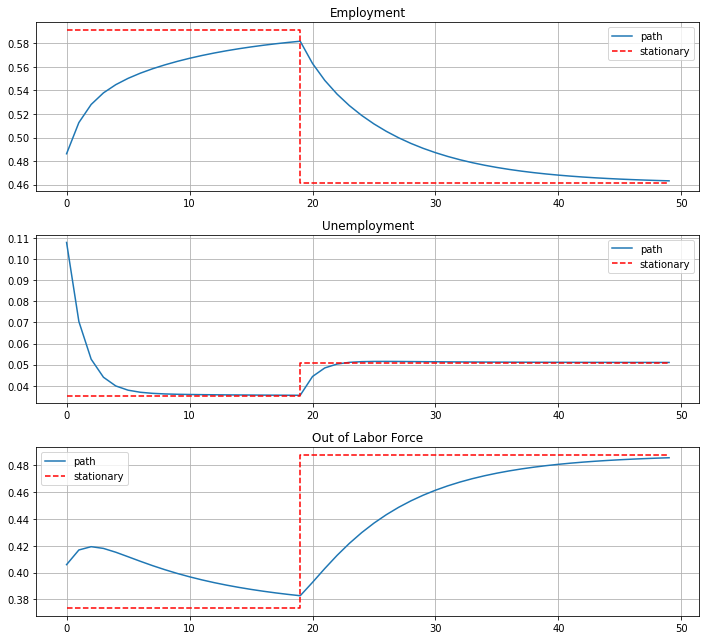

In [19]:
# your code here
# Initialize model
T = 50
T_hat = 20
LM = Lake()

# Simulate until T_hat
path_pre = np.vstack(tuple(LM.simulate_stock_path(X_0, T_hat)))
xbar_pre = LM.steady_state(init=X_0)
xbar_pre = np.tile(xbar_pre, [T_hat, 1])

# Change model params
LM.alpha = 0.03
LM.delta = 0.05

# Simulate until T
path_post = np.vstack(tuple(
    LM.simulate_stock_path(path_pre[-1], T - T_hat + 1)))
xbar_post = LM.steady_state(init=path_pre[-1])
xbar_post = np.tile(xbar_post, [T - T_hat, 1])

# Concat results
path_total = np.vstack([path_pre, path_post[1:]])
xbar_total = np.vstack([xbar_pre, xbar_post])

# Plot the results
fig, axs = plt.subplots(3, 1, figsize=[10, 9])

labels = ["Employment", "Unemployment", "Out of Labor Force"]
for i, ax in enumerate(axs):
    ax.plot(path_total[:, i], label='path')
    ax.plot(xbar_total[:, i], label='stationary', 
            color='red', linestyle='dashed',
            drawstyle='steps-pre')
    ax.set_title(labels[i])
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

### Q.2-6: Effects of Changes in Transition Probabilities on Individual Worker's Turnovers in the Labor Market

Let's simulate an individual worker's turnovers in the labor market stock variables for $T=50,000$ again. Now, suppose that the following changes in transition probabilites will take place in period $\hat{T} = 20,000$: $\hat{\alpha} = 0.03$ and $\hat{\delta} = 0.05$. Write codes for simulating and plotting the individual worker's turnovers across labor market states over time as you did in Q.2-4.


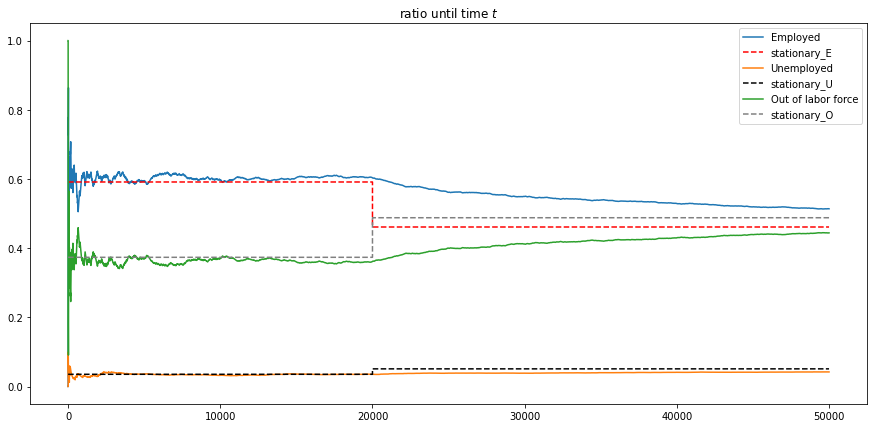

In [20]:
# your code here
np.random.seed(2015121120)
T = 50000
T_hat = 20000
LM = Lake()

s_path_pre = LM.mc.simulate(T_hat)
xbar_pre = LM.steady_state()
xbar_pre = np.tile(xbar_pre, [T_hat, 1])

last_state = s_path_pre[-1]

# Change model params
LM.alpha = 0.03
LM.delta = 0.05

# Simulate until T
s_path_post = LM.mc.simulate(T - T_hat + 1, init=last_state)
s_path_post = s_path_post[1:] # Drop T_hat-th state to avoid doubling
xbar_post = LM.steady_state()
xbar_post = np.tile(xbar_post, [T - T_hat, 1])

# Concat results
s_path_total = np.concatenate([s_path_pre, s_path_post])
xbar_total = np.vstack([xbar_pre, xbar_post])

# Calculate cumulative density
s_bar_e, s_bar_u, s_bar_o = get_cum_density(s_path_total)

# Plot the figures
plt.figure(figsize=(15,7))
plt.title(r'ratio until time $t$')

plt.plot(s_bar_e, label='Employed')
plt.plot(xbar_total[:, 0], color='red', label='stationary_E', 
         linestyle='dashed', drawstyle='steps-pre')

plt.plot(s_bar_u, label='Unemployed')
plt.plot(xbar_total[:, 1], color='black', label='stationary_U', 
         linestyle='dashed', drawstyle='steps-pre')

plt.plot(s_bar_o, label='Out of labor force')
plt.plot(xbar_total[:, 2], color='grey', label='stationary_O',
         linestyle='dashed', drawstyle='steps-pre')

plt.legend()
plt.show()

---
### Simulation with `Lake_modified`

In [21]:
# your code here
LM = Lake_modified()

- check if the labor market is irreducible using a method in `quantecon.MarkovChain`

In [22]:
# your code here
LM.mc.is_irreducible

True

- check if the labor market is aperiodic using a method in `quantecon.MarkovChain`

In [23]:
# your code here
LM.mc.is_aperiodic

True

- compute the stationary distribution of labor market states using the function `stationary_distgribution` **(typo)** included in `quantecon.MarkovChain`.

In [24]:
# your code here
print(LM.mc.stationary_distributions)

[[0.59122535 0.03530098 0.37347367]]


- compute the stationary distribution of labor market states using the function `steady_state` included in the class `Lake`.

In [25]:
# your code here
print(LM.steady_state())

[0.59123378 0.03530079 0.37346543]


### Q.2-3: Simulate Labor Market Stocks

Let's simulate labor market stock variables for 50 periods, `T=50`, according to the system that we constructed with the class `Lake`.

- set initial values for labor market stocks: `X_0`
- compute the steady state of the labor market: `xbar`
- simulate labor market stocks with the function `simulate_stock_path`.
- plot the simulated labor market stock variables with their steady states.


initital  |[0.4862 0.1078 0.406 ] 
steady    |[0.5912 0.0353 0.3735] 
last      |[0.5908 0.0353 0.3739]


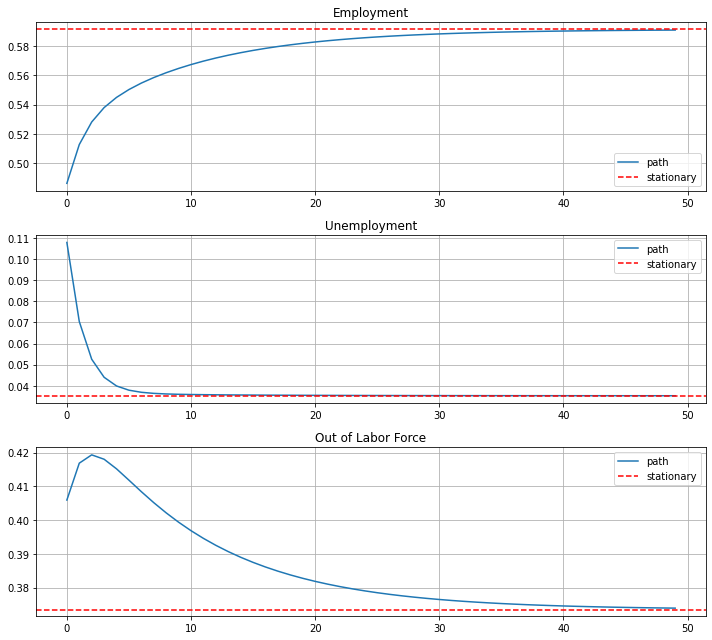

In [26]:
# your code here
np.random.seed(2015121120)
X_0 = np.abs(np.random.randn(3))
X_0 /= np.sum(X_0)

xbar = LM.steady_state(init=X_0)
path = np.vstack(tuple(LM.simulate_stock_path(init=X_0, T=50)))

print(
    f"{'initital':<10}|{str(np.around(X_0, 4)):>}",
    f"\n{'steady':<10}|{str(np.around(xbar, 4)):>}",
    f"\n{'last':<10}|{str(np.around(path[-1], 4)):>}"
)

fig, axs = plt.subplots(3, 1, figsize=[10, 9])

labels = ["Employment", "Unemployment", "Out of Labor Force"]
for i, ax in enumerate(axs):
    ax.plot(path[:, i], label='path')
    ax.axhline(xbar[i], color='red', label='stationary', linestyle='dashed')
    ax.set_title(labels[i])
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

### Q.2-4: An Invididual Worker's Turnover across Labor Market States

Let's simulate an individual worker's turnovers (transitions) across the labor market stock variables for $T=50,000$. Write codes for simulating and plotting the individual worker's turnovers across labor market states over time.

- simuate individual worker's state using Markov chain: `s_path`
- from `s_path`, construct a time series `e_path` that consists of 0 or 1 where 1 represents employment
- from `s_path`, construct a time series `u_path` that consists of 0 or 1 where 1 represents unemployment
- from `s_path`, construct a time series `o_path` that consists of 0 or 1 where 1 represents out of labor force
- using `e_path` generate a time series, `s_bar_e` of percentage of time employed until time $t$
- using `u_path` generate a time series, `s_bar_u` of percentage of time unemployed until time $t$
- using `o_path` generate a time series, `s_bar_o` of percentage of time out of labor force until time $t$
- plot `s_bar_e`, `s_bar_u`, `s_bar_o`

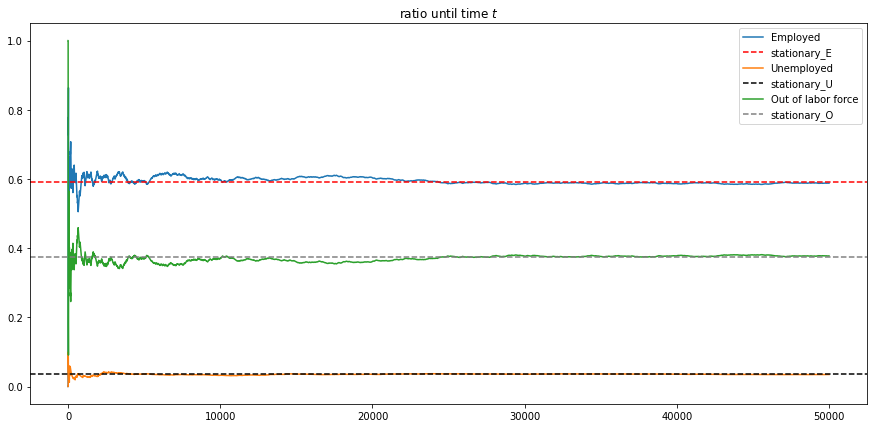

In [27]:
# your code here
np.random.seed(2015121120)
s_path = LM.mc.simulate(50000)
xbar = LM.steady_state()

def get_cum_density(path):
    out = []
    for s in range(3):
        binary_path = np.array(path == s, 'int')
        out.append(np.cumsum(binary_path) / np.arange(1, len(binary_path) + 1))
    return out

s_bar_e, s_bar_u, s_bar_o = get_cum_density(s_path)

plt.figure(figsize=(15,7))
plt.title(r'ratio until time $t$')

plt.plot(s_bar_e, label='Employed')
plt.axhline(xbar[0], color='red', label='stationary_E', linestyle='dashed')

plt.plot(s_bar_u, label='Unemployed')
plt.axhline(xbar[1], color='black', label='stationary_U', linestyle='dashed')

plt.plot(s_bar_o, label='Out of labor force')
plt.axhline(xbar[2], color='grey', label='stationary_O', linestyle='dashed')

plt.legend()
plt.show()

### Q.2-5: Effects of Changes in Transition Probabilities on Labor Market Stocks

Let's simulate the labor market stock variables for $T=50$ again. Now, suppose that the following changes in transition probabilites will take place in period $\hat{T} = 20$: $\hat{\alpha} = 0.03$ and $\hat{\delta} = 0.05$. In other words, exit probabilities from employment to either unemployment or out of labor force will increase. Write codes for simulating and plotting the labor market stocks as you did in Q.2-3.


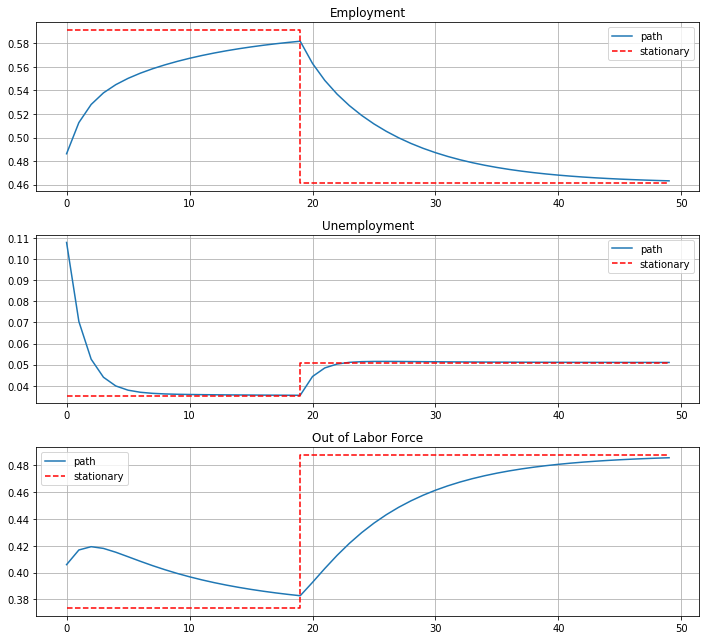

In [28]:
# your code here
# Initialize model
T = 50
T_hat = 20
LM = Lake_modified()

# Simulate until T_hat
path_pre = np.vstack(tuple(LM.simulate_stock_path(X_0, T_hat)))
xbar_pre = LM.steady_state(init=X_0)
xbar_pre = np.tile(xbar_pre, [T_hat, 1])

# Change model params
LM.alpha = 0.03
LM.delta = 0.05

# Simulate until T
path_post = np.vstack(tuple(
    LM.simulate_stock_path(path_pre[-1], T - T_hat + 1)))
xbar_post = LM.steady_state(init=path_pre[-1])
xbar_post = np.tile(xbar_post, [T - T_hat, 1])

# Concat results
path_total = np.vstack([path_pre, path_post[1:]])
xbar_total = np.vstack([xbar_pre, xbar_post])

# Plot the results
fig, axs = plt.subplots(3, 1, figsize=[10, 9])

labels = ["Employment", "Unemployment", "Out of Labor Force"]
for i, ax in enumerate(axs):
    ax.plot(path_total[:, i], label='path')
    ax.plot(xbar_total[:, i], label='stationary', 
            color='red', linestyle='dashed',
            drawstyle='steps-pre')
    ax.set_title(labels[i])
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

### Q.2-6: Effects of Changes in Transition Probabilities on Individual Worker's Turnovers in the Labor Market

Let's simulate an individual worker's turnovers in the labor market stock variables for $T=50,000$ again. Now, suppose that the following changes in transition probabilites will take place in period $\hat{T} = 20,000$: $\hat{\alpha} = 0.03$ and $\hat{\delta} = 0.05$. Write codes for simulating and plotting the individual worker's turnovers across labor market states over time as you did in Q.2-4.


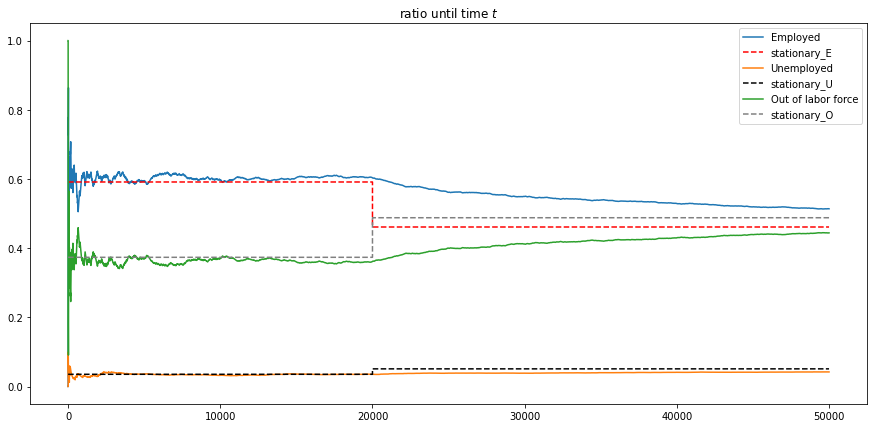

In [29]:
# your code here
np.random.seed(2015121120)
T = 50000
T_hat = 20000
LM = Lake_modified()

s_path_pre = LM.mc.simulate(T_hat)
xbar_pre = LM.steady_state()
xbar_pre = np.tile(xbar_pre, [T_hat, 1])

last_state = s_path_pre[-1]

# Change model params
LM.alpha = 0.03
LM.delta = 0.05

# Simulate until T
s_path_post = LM.mc.simulate(T - T_hat + 1, init=last_state)
s_path_post = s_path_post[1:] # Drop T_hat-th state to avoid doubling
xbar_post = LM.steady_state()
xbar_post = np.tile(xbar_post, [T - T_hat, 1])

# Concat results
s_path_total = np.concatenate([s_path_pre, s_path_post])
xbar_total = np.vstack([xbar_pre, xbar_post])

# Calculate cumulative density
s_bar_e, s_bar_u, s_bar_o = get_cum_density(s_path_total)

# Plot the figures
plt.figure(figsize=(15,7))
plt.title(r'ratio until time $t$')

plt.plot(s_bar_e, label='Employed')
plt.plot(xbar_total[:, 0], color='red', label='stationary_E', 
         linestyle='dashed', drawstyle='steps-pre')

plt.plot(s_bar_u, label='Unemployed')
plt.plot(xbar_total[:, 1], color='black', label='stationary_U', 
         linestyle='dashed', drawstyle='steps-pre')

plt.plot(s_bar_o, label='Out of labor force')
plt.plot(xbar_total[:, 2], color='grey', label='stationary_O',
         linestyle='dashed', drawstyle='steps-pre')

plt.legend()
plt.show()